In [276]:
# Step 1: Import the Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from textblob import TextBlob
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

#Load the Files
user_reviews_df = pd.read_csv('googleplaystore_user_reviews.csv')
app_data_df = pd.read_csv('googleplaystore.csv')
child_app_data_df = pd.read_csv('Apps.csv')
child_review_data_df = pd.read_csv('Reviews.csv')



In [300]:
import pandas as pd

dfParentApps = pd.read_csv("googleplaystore.csv")
dfParentReviews = pd.read_csv("googleplaystore_user_reviews.csv")
dfChildApps = pd.read_csv("Apps.csv")
dfChildReviews = pd.read_csv("Reviews.csv")

# Sütun adlarını yeniden adlandır
dfParentApps.rename(columns={"App": "App Name"}, inplace=True)
dfParentReviews.rename(columns={"App": "App Name"}, inplace=True)
dfChildApps.rename(columns={"title": "App Name", "appId": "app_Id"}, inplace=True)
dfChildReviews.rename(columns={"repliedAt": "Review Date"}, inplace=True)

# Ana veri kümelerini birleştir
mergedMain = pd.merge(dfParentApps, dfParentReviews, on='App Name', how='left')
mergedChild = pd.merge(dfChildApps, dfChildReviews, on='app_Id', how='left')



# Uygulama adları ve inceleme tarihlerini içeren iki DataFrame'i de alalım
mergedAll = pd.merge(mergedMain, mergedChild[['App Name', 'Review Date']], on='App Name', how='left')


mergedAll.drop_duplicates(inplace=True)

# Elde edilen DataFrame'i göster
print(mergedAll)

# Function to detect and handle outliers using IQR method
def handle_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), np.nan, df[col])
    return df

# Convert Size to numeric values (in MB), handling non-numeric values
mergedAll['Size'] = mergedAll['Size'].replace('Varies with device', np.nan)
mergedAll['Size'] = mergedAll['Size'].str.replace('M', '').str.replace('k', 'e-3')
mergedAll['Size'] = pd.to_numeric(mergedAll['Size'], errors='coerce')

# Review Date nan drop
mergedAll.dropna(subset=['Review Date'], inplace=True)

# Drop any remaining rows with missing or non-numeric values in 'Size'
mergedAll.dropna(subset=['Size'], inplace=True)

# Installs to numeric values
mergedAll['Installs'] = mergedAll['Installs'].astype(str).str.replace('+', '').str.replace(',', '').astype(int)

# Encode the Price column
mergedAll['Price'] = mergedAll['Price'].astype(str).str.replace('$', '', regex=False).astype(float)

mergedAll['Size'] = mergedAll['Size'].astype(str).str.replace('M', '', regex=False).astype(float)

mergedAll['Rating'] = mergedAll['Rating'].astype(float)

# Convert 'Review Date' column to datetime format
mergedAll['Review Date'] = pd.to_datetime(mergedAll['Review Date'])

# Change the format of 'Review Date' to dd-mm-yyyy
mergedAll['Review Date'] = mergedAll['Review Date'].dt.strftime('%d-%m-%Y')

print(mergedAll)





                                               App Name             Category  \
0        Photo Editor & Candy Camera & Grid & ScrapBook       ART_AND_DESIGN   
1                                   Coloring book moana       ART_AND_DESIGN   
2                                   Coloring book moana       ART_AND_DESIGN   
3                                   Coloring book moana       ART_AND_DESIGN   
4                                   Coloring book moana       ART_AND_DESIGN   
...                                                 ...                  ...   
3634290                                Sya9a Maroc - FR               FAMILY   
3634291                Fr. Mike Schmitz Audio Teachings               FAMILY   
3634292                          Parkinson Exercices FR              MEDICAL   
3634293                   The SCP Foundation DB fr nn5n  BOOKS_AND_REFERENCE   
3634294   iHoroscope - 2018 Daily Horoscope & Astrology            LIFESTYLE   

         Rating Reviews                

In [302]:


#Standart Scaler
numeric_cols = ['Rating', 'Reviews', 'Size', 'Installs', 'Sentiment_Polarity', 'Sentiment_Subjectivity']

# Step 5: Do Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(mergedAll[numeric_cols])

# Convert scaled features back to DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=numeric_cols)

# Include categorical variables
categorical_vars = mergedAll[['Category', 'Type', 'Content Rating', 'Genres']]

# Encode categorical variables
label_encoder = LabelEncoder()
for col in categorical_vars.columns:
    categorical_vars[col] = label_encoder.fit_transform(categorical_vars[col])

# Combine scaled features and encoded categorical variables
final_df = pd.concat([scaled_df, categorical_vars.reset_index(drop=True)], axis=1)

# Step 6: Split the Data
X = final_df.drop('Rating', axis=1)
y = final_df['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display training and test sets
print("Training Set:")
print(X_train.head())

print("\nTest Set:")
print(X_test.head())

Training Set:
       Reviews      Size  Installs  Sentiment_Polarity  \
548  -0.459961 -1.234766 -0.458118                 NaN   
5045 -0.190955  0.781699 -0.021225                 NaN   
3908  0.033603  0.827217 -0.021225           -1.090342   
6073 -0.401734 -0.902482 -0.418400            0.150665   
4520  0.042449  0.918254 -0.021225                 NaN   

      Sentiment_Subjectivity  Category  Type  Content Rating  Genres  
548                      NaN         3     0               2       5  
5045                     NaN         4     0               0       5  
3908               -1.485098         9     0               0       9  
6073                0.959446         6     0               0       6  
4520                     NaN         4     0               1       5  

Test Set:
       Reviews      Size  Installs  Sentiment_Polarity  \
5436 -0.394061  1.601030  1.743999                 NaN   
2860  0.033586  0.827217 -0.021225           -1.090342   
2851  0.033586  0.827217 -

In [301]:
#EDA PART
print("Basic Statistics:")
print(mergedAll.describe())

Basic Statistics:
            Rating         Size      Installs   Price  Sentiment_Polarity  \
count  6534.000000  6534.000000  6.534000e+03  6534.0         2896.000000   
mean      4.453336    34.826752  1.048096e+08     0.0            0.308423   
std       0.188545    21.970818  2.266175e+08     0.0            0.282917   
min       4.100000     4.400000  5.000000e+05     0.0           -0.250000   
25%       4.400000    15.000000  1.000000e+07     0.0            0.000000   
50%       4.400000    37.000000  5.000000e+07     0.0            0.308333   
75%       4.500000    53.000000  1.000000e+08     0.0            0.500000   
max       4.900000    77.000000  1.000000e+09     0.0            1.000000   

       Sentiment_Subjectivity  
count             2896.000000  
mean                 0.415136  
std                  0.279582  
min                  0.000000  
25%                  0.000000  
50%                  0.502976  
75%                  0.600000  
max                  0.900000  


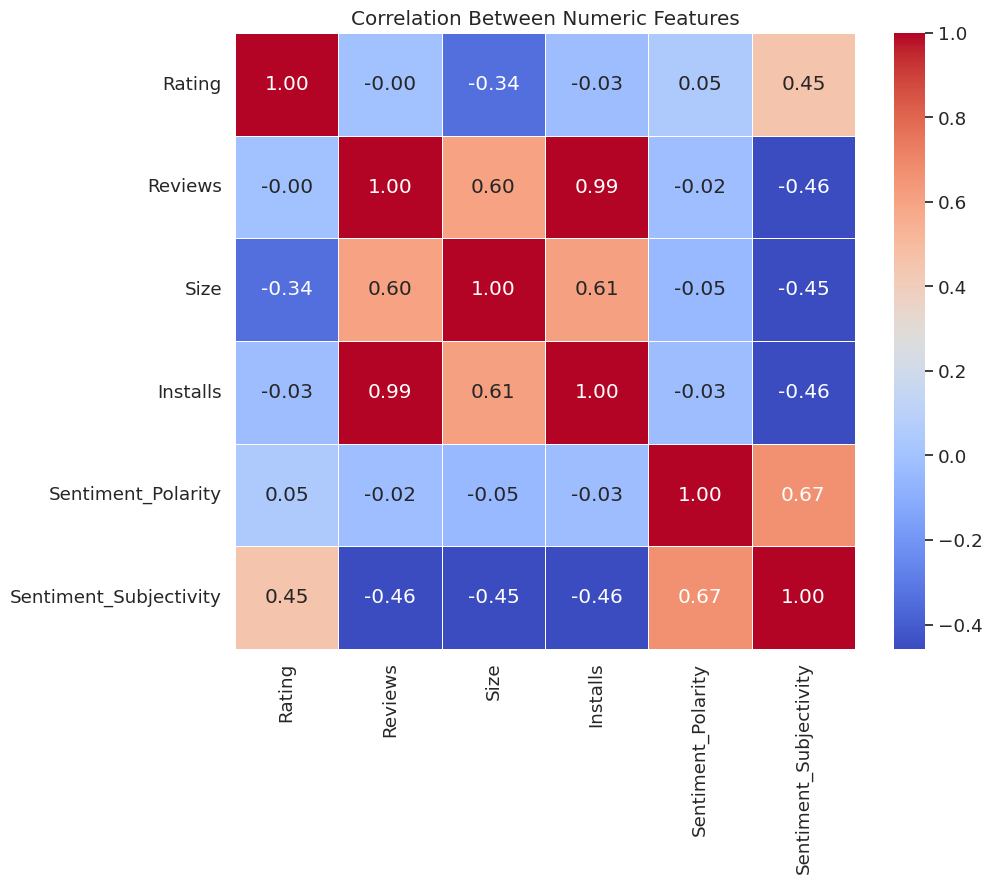

In [303]:
numeric_data = mergedAll[numeric_cols]

# Correlation matrix for numeric data
corr_matrix = numeric_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Between Numeric Features')
plt.show()

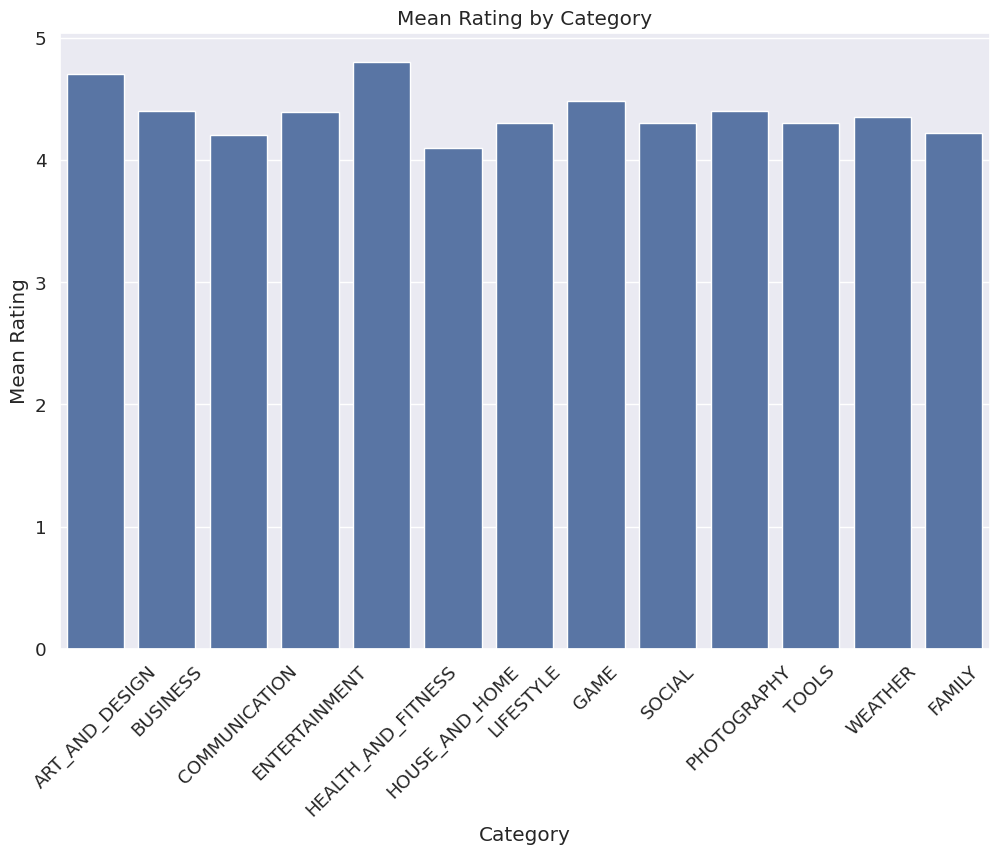

In [304]:
# Bar plot of mean Rating by Category
plt.figure(figsize=(12, 8))
sns.barplot(x='Category', y='Rating', data=mergedAll, ci=None)  # ci=None to remove error bars
plt.title('Mean Rating by Category')
plt.xticks(rotation=45)
plt.ylabel('Mean Rating')
plt.xlabel('Category')
plt.show()


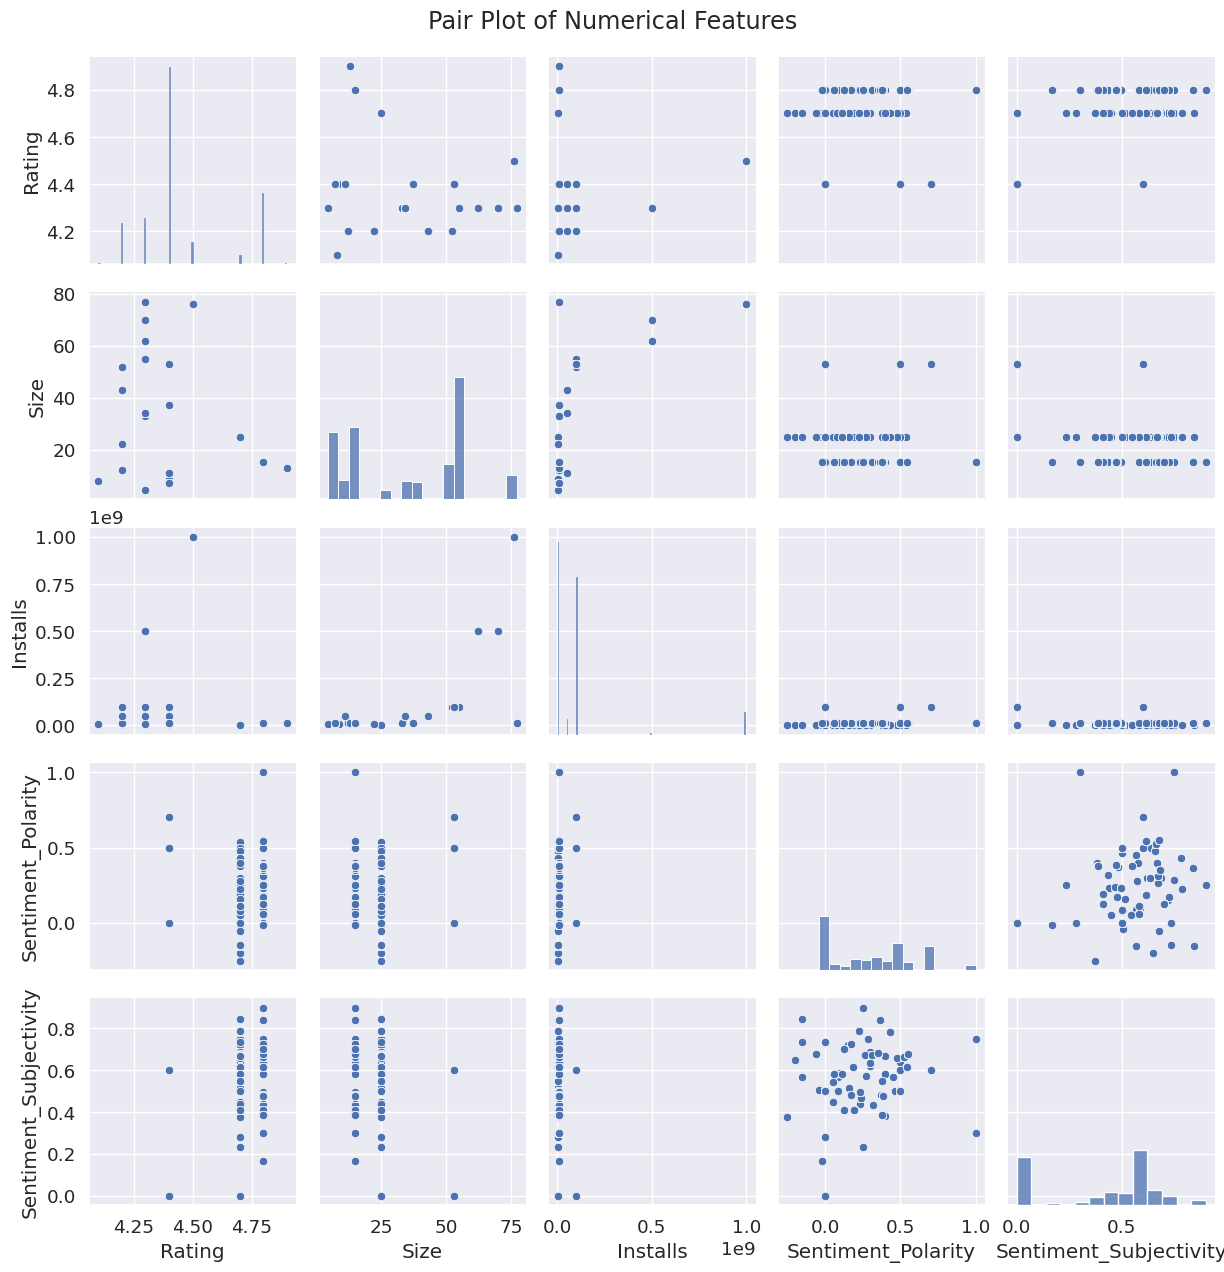

In [305]:
# Relationship Between Features (Pair Plot)
sns.pairplot(mergedAll[['Rating', 'Reviews', 'Size', 'Installs', 'Sentiment_Polarity', 'Sentiment_Subjectivity']])
plt.suptitle('Pair Plot of Numerical Features', y=1.02)
plt.show()

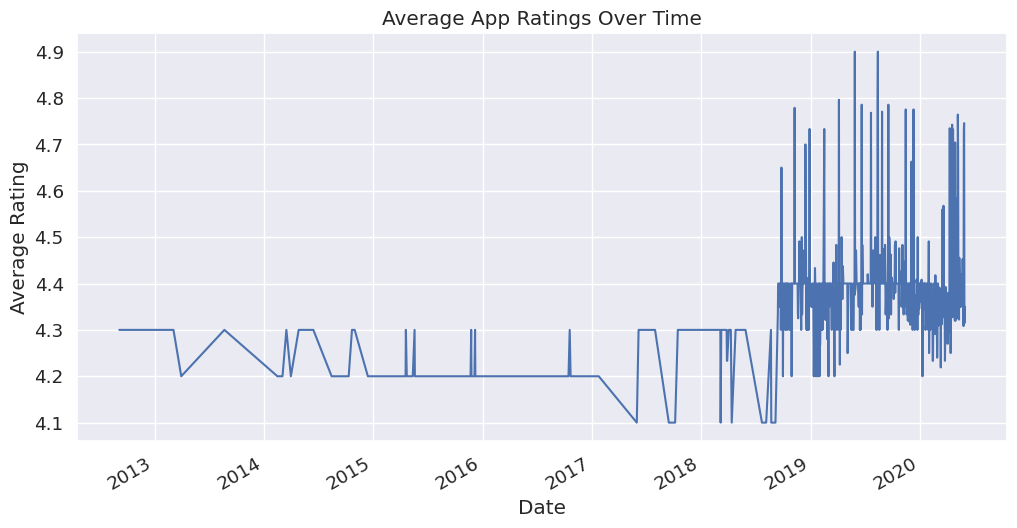

In [306]:
# App Ratings Over Time (Assuming 'Review Date' is available)
mergedAll['Review Date'] = pd.to_datetime(mergedAll['Review Date'])
ratings_over_time = mergedAll.groupby('Review Date')['Rating'].mean()
plt.figure(figsize=(12, 6))
ratings_over_time.plot()
plt.title('Average App Ratings Over Time')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.show()
